In [1]:
import os
import shutil
from pathlib import Path
from cryptovision.tools import CryptoVisionAI, get_taxonomic_mappings_from_folders

def organize_images_by_predictions(
    ai: CryptoVisionAI,
    image_directory: str,
    output_directory: str,
    confidence_threshold: float = 0.5,
):
    """
    Organize images into directories based on model predictions.

    Parameters:
        model_path (str): Path to the trained model file.
        image_directory (str): Path to the directory containing images.
        output_directory (str): Path to save organized images.
        confidence_threshold (float): Minimum confidence score to accept a prediction.
    """
    
    # Ensure output directory exists
    os.makedirs(output_directory, exist_ok=True)

    # Prepare an "unknown" directory for low-confidence predictions
    unknown_dir = os.path.join(output_directory, "unknown")
    os.makedirs(unknown_dir, exist_ok=True)

    # Process each image in the input directory
    for root, _, files in os.walk(image_directory):
        for file in files:
            if not file.lower().endswith((".jpg", ".jpeg", ".png")) or file.startswith("."):
                continue

            image_path = os.path.join(root, file)

            # Predict family, genus, and species using CryptoVisionAI
            prediction = ai.predict(image_path)
            family_name, genus_name, species_name = prediction

            family_conf, genus_conf, species_conf = ai.confidence

            # Determine the target directory and filename based on confidence
            if species_conf >= confidence_threshold:
                # Use species-level directory and naming
                target_dir = os.path.join(output_directory, family_name, genus_name)
                os.makedirs(target_dir, exist_ok=True)
                base_name, ext = os.path.splitext(file)
                new_name = f"{base_name}_{species_name}{ext}"
            elif genus_conf >= confidence_threshold:
                # Use genus-level directory and naming
                target_dir = os.path.join(output_directory, family_name, genus_name)
                os.makedirs(target_dir, exist_ok=True)
                base_name, ext = os.path.splitext(file)
                new_name = f"{base_name}_{genus_name}{ext}"
            elif family_conf >= confidence_threshold:
                # Use family-level directory and naming
                target_dir = os.path.join(output_directory, family_name)
                os.makedirs(target_dir, exist_ok=True)
                base_name, ext = os.path.splitext(file)
                new_name = f"{base_name}_{family_name}{ext}"
            else:
                # Use unknown directory
                target_dir = unknown_dir
                new_name = file

            target_path = os.path.join(target_dir, new_name)

            # Copy the image to the target directory with the new name
            shutil.copy(image_path, target_path)

    print(f"Images organized in {output_directory}")

2025-01-15 15:18:06.042 | INFO     | cryptovision.config:<module>:15 - PROJ_ROOT path is: /Users/leonardo/Documents/Projects/cryptovision


In [2]:
def organize_images_by_predictions(
    ai: CryptoVisionAI,
    image_directory: str,
    output_directory: str,
    confidence_thresholds: dict = {"family": 0.5, "genus": 0.6, "species": 0.7},
    taxonomy_directory: str = None
):
    """
    Organize images into directories based on model predictions and confidence levels.

    Parameters:
        ai (CryptoVisionAI): An instance of the CryptoVisionAI class.
        image_directory (str): Path to the directory containing images.
        output_directory (str): Path to save organized images.
        confidence_thresholds (dict): Minimum confidence scores for family, genus, and species predictions.
        taxonomy_directory (str): Path to a directory with subfolders named as 'family_genus_species' to generate taxonomy mappings.
    """
    # Ensure output directory exists
    os.makedirs(output_directory, exist_ok=True)

    # Prepare "unknown" and "genus_only" directories
    unknown_dir = os.path.join(output_directory, "unknown")
    genus_only_dir = os.path.join(output_directory, "genus_only")
    os.makedirs(unknown_dir, exist_ok=True)
    os.makedirs(genus_only_dir, exist_ok=True)

    # Generate taxonomy mappings dynamically if taxonomy_directory is provided
    if taxonomy_directory:
        genus_to_family, species_to_genus = get_taxonomic_mappings_from_folders(taxonomy_directory)
    else:
        genus_to_family, species_to_genus = {}, {}

    # Process each image in the input directory
    for root, _, files in os.walk(image_directory):
        for file in files:
            if not file.lower().endswith((".jpg", ".jpeg", ".png")) or file.startswith("."):
                continue

            image_path = os.path.join(root, file)

            # Predict family, genus, and species using CryptoVisionAI
            prediction = ai.predict(image_path)
            family_name, genus_name, species_name = prediction

            # Retrieve confidence scores
            family_conf, genus_conf, species_conf = ai.confidence

            # Determine the target directory and filename based on confidence
            if species_conf >= confidence_thresholds["species"]:
                # Species-level classification
                target_dir = os.path.join(output_directory, family_name, genus_name, species_name)
                os.makedirs(target_dir, exist_ok=True)
                base_name, ext = os.path.splitext(file)
                new_name = f"{base_name}_{species_name}{ext}"
            elif genus_conf >= confidence_thresholds["genus"]:
                # Genus-level classification
                if family_name is None:
                    # If family is invalid, use genus_only directory
                    target_dir = os.path.join(genus_only_dir, genus_name)
                else:
                    target_dir = os.path.join(output_directory, family_name, genus_name)
                os.makedirs(target_dir, exist_ok=True)
                base_name, ext = os.path.splitext(file)
                new_name = f"{base_name}_{genus_name}{ext}"
            elif family_conf >= confidence_thresholds["family"]:
                # Family-level classification
                target_dir = os.path.join(output_directory, family_name)
                os.makedirs(target_dir, exist_ok=True)
                base_name, ext = os.path.splitext(file)
                new_name = f"{base_name}_{family_name}{ext}"
            else:
                # Unknown classification
                target_dir = unknown_dir
                new_name = file

            target_path = os.path.join(target_dir, new_name)

            # Copy the image to the target directory with the new name
            shutil.copy(image_path, target_path)

    print(f"Images organized in {output_directory}")


In [3]:
# Extract family, genus, and species labels from the folder structure
IMAGES_DATASET_PATH = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/cv_images_dataset'
TRAINED_MODEL_PATH = '/Users/leonardo/Documents/Projects/cryptovision/models/phorcys_v09_hacpl_rn50v2_v2411251155.keras'

family_labels, genus_labels, species_labels, _, _ = get_taxonomic_mappings_from_folders(IMAGES_DATASET_PATH)

# Initialize CryptoVisionAI instance with labels
ai = CryptoVisionAI(model_path=TRAINED_MODEL_PATH, family_names=family_labels, genus_names=genus_labels, species_names=species_labels)

2024-12-27 10:46:39.853141: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-12-27 10:46:39.853172: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-12-27 10:46:39.853177: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-12-27 10:46:39.853192: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-27 10:46:39.853203: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/leonardo/miniconda3/envs/cvenv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has

In [4]:
family_labels

['Apogonidae',
 'Blenniidae',
 'Chaenopsidae',
 'Chaetodontidae',
 'Cirrhitidae',
 'Creediidae',
 'Gobiidae',
 'Labridae',
 'Plesiopidae',
 'Pomacanthidae',
 'Pomacentridae',
 'Pseudochromidae',
 'Sciaenidae',
 'Scorpaenidae',
 'Serranidae',
 'Syngnathidae',
 'Tetraodontidae',
 'Tripterygiidae']

In [3]:
organize_images_by_predictions(
        ai,
        image_directory = f"/Volumes/T7_shield/CryptoVision/Data/sjb/full_raw",
        output_directory = '/Volumes/T7_shield/CryptoVision/Data/sjb/full_raw_cv_organized',
        confidence_threshold = 0.75,
    )

2024-12-23 19:38:54.274244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Images organized in /Volumes/T7_shield/CryptoVision/Data/sjb/full_raw_cv_organized


In [55]:
folders_list = [
    'Site F - Site G',
    'Site H - Site I',
    'Site J - Site K',
    'Site L',
    'Site M',
    'Site N',
    'Site O',
    'Site P',
    'Site Q',
    'Site R',
    'Site S',
    'Site T',
    'Site U',
    'Site V',
]


for folder in folders_list:
    print(f"Start organizing {folder}...")
    organize_images_by_predictions(
        ai,
        image_directory = f"/Volumes/T7_shield/CryptoVision/Data/others/{folder}",
        output_directory = '/Volumes/T7_shield/CryptoVision/Data/others/cv_organizer_v2',
        confidence_threshold = 0.75,
    )
    print(f"Organizing {folder} completed.")
    print(f"____________________\n")

Start organizing Site F - Site G...
Images organized in /Volumes/T7_shield/CryptoVision/Data/others/cv_organizer_v2
Organizing Site F - Site G completed.
____________________

Start organizing Site H - Site I...
Images organized in /Volumes/T7_shield/CryptoVision/Data/others/cv_organizer_v2
Organizing Site H - Site I completed.
____________________

Start organizing Site J - Site K...
Images organized in /Volumes/T7_shield/CryptoVision/Data/others/cv_organizer_v2
Organizing Site J - Site K completed.
____________________

Start organizing Site L...
Images organized in /Volumes/T7_shield/CryptoVision/Data/others/cv_organizer_v2
Organizing Site L completed.
____________________

Start organizing Site M...
Images organized in /Volumes/T7_shield/CryptoVision/Data/others/cv_organizer_v2
Organizing Site M completed.
____________________

Start organizing Site N...
Images organized in /Volumes/T7_shield/CryptoVision/Data/others/cv_organizer_v2
Organizing Site N completed.
____________________

In [4]:
import os
import random
from pptx import Presentation
from pptx.util import Inches, Pt
from PIL import Image
from io import BytesIO

def create_collage(images, collage_width=800, collage_height=600):
    """
    Create a collage of images.
    """
    collage = Image.new('RGB', (collage_width, collage_height), color=(255, 255, 255))

    # Calculate grid layout
    rows = cols = 3  # for a 3x3 grid (9 images per slide)
    thumb_width = collage_width // cols
    thumb_height = collage_height // rows

    for i, image_path in enumerate(images):
        img = Image.open(image_path)
        img.thumbnail((thumb_width, thumb_height))

        x = (i % cols) * thumb_width
        y = (i // cols) * thumb_height

        collage.paste(img, (x, y))

    return collage

def generate_presentation(folder_path, output_pptx):
    """
    Generate a PowerPoint presentation with collages from each subfolder.
    """
    presentation = Presentation()

    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            images = [os.path.join(subfolder_path, img) for img in os.listdir(subfolder_path) if img.lower().endswith(('png', 'jpg', 'jpeg'))]

            if len(images) < 9:
                print(f"Not enough images in {subfolder_path} (found {len(images)})")
                continue

            # Randomly select 9 images
            selected_images = random.sample(images, 9)

            # Create collage
            collage = create_collage(selected_images)

            # Save collage to a BytesIO buffer
            collage_buffer = BytesIO()
            collage.save(collage_buffer, format='PNG')
            collage_buffer.seek(0)

            # Add slide
            slide = presentation.slides.add_slide(presentation.slide_layouts[5])

            # Add title
            title = slide.shapes.title
            title.text = subfolder.replace('_', ' ')
            title.text_frame.paragraphs[0].font.size = Pt(28)  # Reduce font size by 20%

            # Add collage image
            left = Inches(1)
            top = Inches(1.5)
            pic = slide.shapes.add_picture(collage_buffer, left, top, width=Inches(8), height=Inches(6))

    # Save the presentation
    presentation.save(output_pptx)
    print(f"Presentation saved to {output_pptx}")

# Example usage
folder_path = "/Users/leonardo/Documents/Projects/cryptovision/data/processed/cv_images_dataset"  # Replace with the path to your folder containing subfolders of images
output_pptx = "fish_presentation_v2.pptx"
generate_presentation(folder_path, output_pptx)


Presentation saved to fish_presentation_v2.pptx


In [7]:
import os
import random
from pptx import Presentation
from pptx.util import Inches, Pt
from PIL import Image
from io import BytesIO

def create_collage(images, collage_width=800, collage_height=600):
    """
    Create a collage of images.
    """
    collage = Image.new('RGB', (collage_width, collage_height), color=(255, 255, 255))

    # Calculate grid layout
    rows = cols = 3  # for a 3x3 grid (9 images per slide)
    thumb_width = collage_width // cols
    thumb_height = collage_height // rows

    for i, image_path in enumerate(images):
        img = Image.open(image_path)
        img.thumbnail((thumb_width, thumb_height))

        x = (i % cols) * thumb_width
        y = (i // cols) * thumb_height

        collage.paste(img, (x, y))

    return collage

def generate_presentation(folder_path, output_pptx):
    """
    Generate a PowerPoint presentation with collages from each subfolder.
    """
    presentation = Presentation()

    subfolders = sorted(os.listdir(folder_path))
    for subfolder in subfolders:
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            images = [os.path.join(subfolder_path, img) for img in os.listdir(subfolder_path) if img.lower().endswith(('png', 'jpg', 'jpeg'))]

            if len(images) < 9:
                print(f"Not enough images in {subfolder_path} (found {len(images)})")
                continue

            # Randomly select 9 images
            selected_images = random.sample(images, 9)

            # Create collage
            collage = create_collage(selected_images)

            # Save collage to a BytesIO buffer
            collage_buffer = BytesIO()
            collage.save(collage_buffer, format='PNG')
            collage_buffer.seek(0)

            # Add slide
            slide = presentation.slides.add_slide(presentation.slide_layouts[5])

            # Add title
            title = slide.shapes.title
            title.text = subfolder.replace('_', ' ')
            title.text_frame.paragraphs[0].font.size = Pt(28)  # Reduce font size by 20%

            # Add collage image
            left = Inches(1)
            top = Inches(1.5)
            pic = slide.shapes.add_picture(collage_buffer, left, top, width=Inches(8), height=Inches(6))

    # Save the presentation
    presentation.save(output_pptx)
    print(f"Presentation saved to {output_pptx}")

# Example usage
folder_path = "/Users/leonardo/Documents/Projects/cryptovision/data/processed/cv_images_dataset"  # Replace with the path to your folder containing subfolders of images
output_pptx = "fish_presentation_v3.pptx"
generate_presentation(folder_path, output_pptx)


Presentation saved to fish_presentation_v3.pptx


In [24]:
import tensorflow as tf

def resize_with_padding(img, target_size=384):
    #img = tf.image.resize_with_pad(img, target_size, target_size)
    img = tf.image.resize(img, (target_size, target_size))
    return img


In [12]:
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img


In [20]:
import tensorflow as tf
import matplotlib.pyplot as plt


def display_resized_image(image_path, target_size=384):
    # Load image
    img = load_image(image_path)
    
    # Resize with padding
    resized_img = resize_with_padding(img, target_size)
    
    # Convert tensor to numpy for plotting
    resized_img = resized_img.numpy().astype("uint8")
    
    # Plot the image
    plt.figure(figsize=(6, 6))
    plt.imshow(resized_img)
    plt.title("Resized Image with Padding")
    plt.axis("off")
    plt.show()


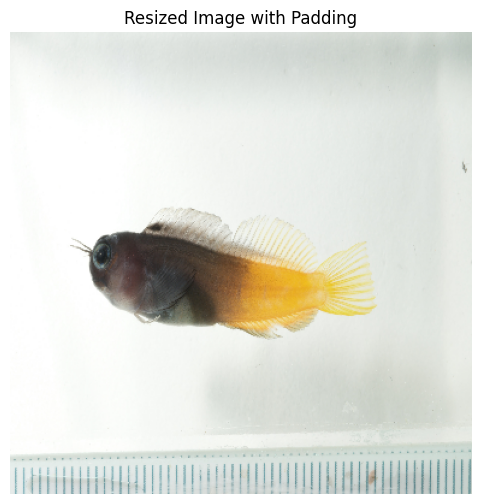

In [25]:
display_resized_image('/Volumes/T7_shield/CryptoVision/Data/sjb/full_raw_cv_organized/Blenniidae/LIRS18_015_B1_138_JMC_3618_Blenniidae.jpeg', target_size=384)

In [4]:
import os
import pandas as pd
from PIL import Image
from io import BytesIO
import xlsxwriter


def resize_image(image_path, size=(512, 512)):
    """
    Resize an image to the specified size.
    """
    with Image.open(image_path) as img:
        img.thumbnail(size)
        buffer = BytesIO()
        img.save(buffer, format="PNG")
        return buffer.getvalue()


def create_excel_from_images(folder_path, excel_path="images_catalog.xlsx"):
    """
    Create an Excel file listing images in the specified folder.

    Parameters:
    folder_path (str): Path to the folder containing images.
    excel_path (str): Path to save the Excel file.
    """
    data = []
    
    # Walk through folder and collect image data
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                full_path = os.path.join(root, file)
                folder_name = os.path.basename(root)
                resized_image = resize_image(full_path)
                data.append((full_path, folder_name, resized_image))
    
    # Create a Pandas DataFrame
    df = pd.DataFrame(data, columns=["image_path", "folder_name", "image"])
    
    # Write to Excel
    with pd.ExcelWriter(excel_path, engine='xlsxwriter') as writer:
        df.drop(columns=["image"]).to_excel(writer, index=False, sheet_name='Images')

        workbook = writer.book
        worksheet = writer.sheets['Images']
        
        for i, (_, row) in enumerate(df.iterrows()):
            image_data = row['image']
            worksheet.insert_image(i + 1, 1, row['image_path'], {'image_data': BytesIO(image_data), 'x_scale': 0.5, 'y_scale': 0.5})
    
    print(f"Excel file created at: {excel_path}")


if __name__ == "__main__":
    folder_path = input("Enter the path to the folder: ")
    create_excel_from_images(folder_path)




Excel file created at: images_catalog.xlsx


In [1]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.ImageClassificationDirectoryTree,
    data_path="/Users/leonardo/Documents/Projects/cryptovision/data/processed/cv_images_dataset",
    #labels_path="/path/to/labels"
)

session = fo.launch_app(dataset)


ValueError: Failed to construct importer of type <class 'fiftyone.utils.data.importers.ImageClassificationDirectoryTreeImporter'> using the provided parameters. See above for the error. You may need to supply additional mandatory arguments. Please consult the documentation of <class 'fiftyone.utils.data.importers.ImageClassificationDirectoryTreeImporter'> to learn more